In [1]:
import pickle
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
class CIFAR10Loader:
    label_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ]
    batch_files = [
        'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4',
        'data_batch_5'
    ]

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.data_batches = []
        for batch_file in self.batch_files:
            file_path = os.path.join(data_dir, batch_file)
            self.data_batches.append(self.load_cifar10_batch(file_path))

    def load_cifar10_batch(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def get_image_and_channels_by_index(self,
                                        batch_index,
                                        img_index,
                                        enlarge=False,
                                        scale=5):
        batch = self.data_batches[batch_index]
        images = batch[b'data']
        labels = batch[b'labels']
        img = images[img_index]
        label = labels[img_index]
        img_r = img[0:1024].reshape(32, 32)
        img_g = img[1024:2048].reshape(32, 32)
        img_b = img[2048:].reshape(32, 32)
        img_color = np.dstack((img_r, img_g, img_b))
        img_color = Image.fromarray(img_color)
        imgs_channels = [Image.fromarray(ch) for ch in [img_r, img_g, img_b]]
        if enlarge:
            img_color = img_color.resize((32 * scale, 32 * scale),
                                         Image.NEAREST)
            imgs_channels = [
                ch.resize((32 * scale, 32 * scale), Image.NEAREST)
                for ch in imgs_channels
            ]
        return img_color, imgs_channels, CIFAR10Loader.label_names[label]

    def show_image(self,
                   batch_index,
                   img_index,
                   mode='color',
                   enlarge=False,
                   scale=5):
        img_color, imgs_channels, label = self.get_image_and_channels_by_index(
            batch_index, img_index, enlarge, scale)
        if mode == 'color':
            img_color.show()
        else:
            for i, ch in enumerate(['R', 'G', 'B']):
                if mode == ch.lower():
                    imgs_channels[i].show()
                    break
        print(
            f"Batch: {batch_index + 1}, Index: {img_index}, Mode: {mode.upper()}, Label: {label}"
        )
        print('---' * 20)

    def show_random_image(self, mode='color', enlarge=False, scale=5):
        batch_index = random.randint(0, len(self.data_batches) - 1)
        img_index = random.randint(
            0,
            len(self.data_batches[batch_index][b'data']) - 1)
        self.show_image(batch_index, img_index, mode, enlarge, scale)

    def show_specific_image(self,
                            batch,
                            index,
                            mode='color',
                            enlarge=False,
                            scale=5):
        if batch < 1 or batch > len(self.data_batches):
            print("Batch number out of range. Please choose between 1 and",
                  len(self.data_batches))
            return
        batch_index = batch - 1  # Adjusting batch number to match Python's 0-indexing
        if index < 0 or index >= len(self.data_batches[batch_index][b'data']):
            print("Index out of range for the selected batch.")
            return
        self.show_image(batch_index, index, mode, enlarge, scale)

    def show_image_histogram(self,
                             batch_index,
                             img_index,
                             enlarge=False,
                             scale=5):
        img_color, _, _ = self.get_image_and_channels_by_index(
            batch_index, img_index, enlarge, scale)
        img_color = np.array(img_color)  # 确保图像是 numpy 数组格式

        # 计算并绘制直方图
        color = ('r', 'g', 'b')
        for i, col in enumerate(color):
            hist = np.histogram(img_color[:, :, i], bins=np.arange(257))[0]
            plt.plot(hist, color=col)
            plt.xlim([0, 256])

        plt.title('Color Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()


    def calculate_hog_features(self, image, visualize=True):
        """
        计算并可视化图像的HOG特征。
        """
        hog_features, hog_image = feature.hog(image, orientations=8, pixels_per_cell=(16, 16),
                                              cells_per_block=(1, 1), visualize=visualize, channel_axis=-1)

        if visualize:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG Visualization')

            plt.show()

        return hog_features

    def calculate_lbp_features(self, image, visualize=True, method='uniform'):
        """
        计算并可视化图像的LBP特征。
        """
        
        # 如果传入的是PIL图像，将其转换为numpy数组
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        lbp = feature.local_binary_pattern(image_gray, P=8, R=1, method=method)

        if visualize:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(lbp, cmap='gray')
            plt.title('LBP Image')

            plt.show()

        # Optionally, compute a histogram of the LBP
        n_bins = int(lbp.max() + 1)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        return lbp_hist

In [3]:
# 使用示例
data_dir = '/data/Pein/Pytorch/Ascend-NPU-Parallel-Training/cifar10_data/cifar-10-batches-py'
cifar_loader = CIFAR10Loader(data_dir)
scale = 10

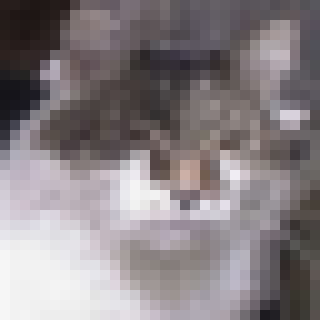

Batch: 5, Index: 8686, Mode: COLOR, Label: cat
------------------------------------------------------------


In [4]:
cifar_loader.show_random_image(mode='color', enlarge=True, scale=scale)
# cifar_loader.show_random_image(mode='g', enlarge=True, scale=scale)

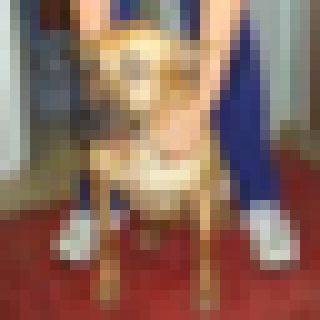

Batch: 1, Index: 51, Mode: COLOR, Label: dog
------------------------------------------------------------


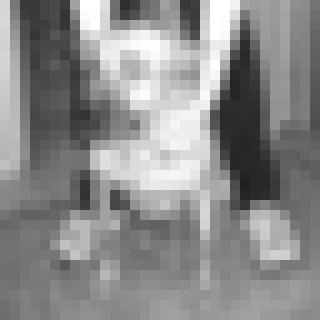

Batch: 1, Index: 51, Mode: R, Label: dog
------------------------------------------------------------


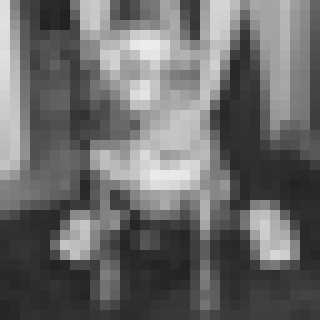

Batch: 1, Index: 51, Mode: G, Label: dog
------------------------------------------------------------


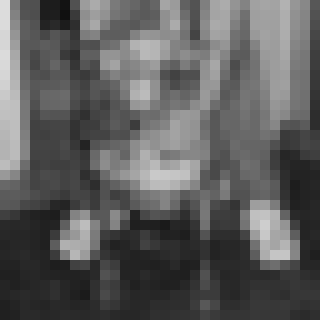

Batch: 1, Index: 51, Mode: B, Label: dog
------------------------------------------------------------


In [5]:
spc_batch, spc_index = 1, 51
cifar_loader.show_specific_image(batch=spc_batch,
                                 index=spc_index,
                                 mode='color',
                                 enlarge=True,
                                 scale=scale)

cifar_loader.show_specific_image(batch=spc_batch,
                                 index=spc_index,
                                 mode='r',
                                 enlarge=True,
                                 scale=scale)

cifar_loader.show_specific_image(batch=spc_batch,
                                 index=spc_index,
                                 mode='g',
                                 enlarge=True,
                                 scale=scale)

cifar_loader.show_specific_image(batch=spc_batch,
                                 index=spc_index,
                                 mode='b',
                                 enlarge=True,
                                 scale=scale)


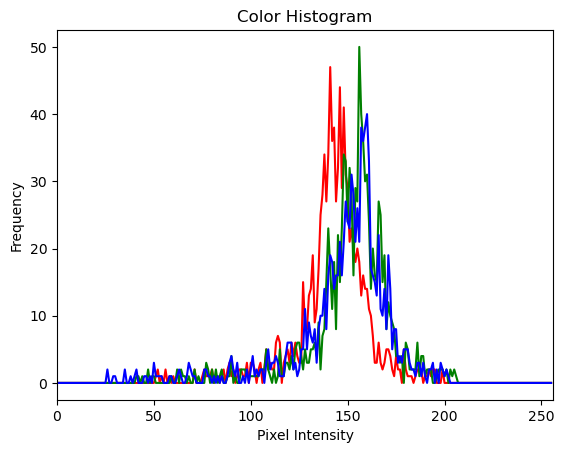

In [6]:
cifar_loader.show_image_histogram(batch_index=spc_batch, img_index=spc_index)

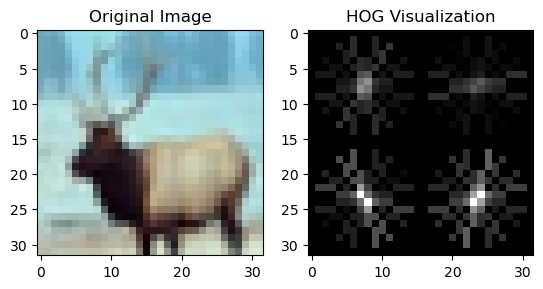

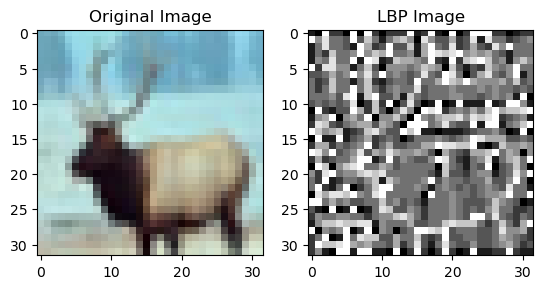

In [7]:
# cifar_loader = CIFAR10Loader(data_dir)  # 创建CIFAR10Loader实例
spc_batch, spc_index = 1, 55
img_color, _, _ = cifar_loader.get_image_and_channels_by_index(batch_index=spc_batch,
                                                               img_index=spc_index)

# 计算HOG特征
hog_features = cifar_loader.calculate_hog_features(img_color)

# 计算LBP特征
lbp_features = cifar_loader.calculate_lbp_features(img_color)
